<a href="https://colab.research.google.com/github/AlexandraPotekhina/VKR_Final/blob/main/VKR_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Загружаем необходимые библиотеки.

In [ ]:
!pip install numpy pandas seaborn tensorflow matplotlib scikit-learn

In [ ]:
pip install protobuf==3.20.0

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.dummy import DummyRegressor
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#%matplotlib inline

RANDOM_STATE = 42

Считываем базы данных и проверяем их размерность.

In [24]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# df_bp = pd.read_excel('/content/drive/MyDrive/X_bp.xlsx')
# df_nup = pd.read_excel('/content/drive/MyDrive/X_nup.xlsx')

In [315]:
df_bp = pd.read_excel('data/X_bp.xlsx', index_col=0)
df_nup = pd.read_excel('data/X_nup.xlsx', index_col=0)

In [32]:
print(df_bp.shape)
print(df_nup.shape)

(1023, 10)
(1040, 3)


Датасет состоит из двух файлов - df_bp (составляющая из базальтопластика) и df_nup (составляющая из углепластика). В рамках задачи необходоимо провести объединение по индексу типа INNER.

In [316]:
df = df_bp.merge(df_nup, how = 'inner', left_index = True, right_index = True)
df.head()

Соотношение матрица-наполнитель  Плотность, кг/м3  модуль упругости, ГПа  \
0.0                         1.857143            2030.0             738.736842   
1.0                         1.857143            2030.0             738.736842   
2.0                         1.857143            2030.0             738.736842   
3.0                         1.857143            2030.0             738.736842   
4.0                         2.771331            2030.0             753.000000   

     Количество отвердителя, м.%  Содержание эпоксидных групп,%_2  \
0.0                        30.00                        22.267857   
1.0                        50.00                        23.750000   
2.0                        49.90                        33.000000   
3.0                       129.00                        21.250000   
4.0                       111.86                        22.267857   

     Температура вспышки, С_2  Поверхностная плотность, г/м2  \
0.0                100.000000                          210.0   
1.0                284.615385                          210.0   
2.0                284.615385                          210.0   
3.0                300.000000                          210.0   
4.0                284.615385                          210.0   

     Модуль упругости при растяжении, ГПа  Прочность при растяжении, МПа  \
0.0                                  70.0                         3000.0   
1.0                                  70.0                         3000.0   
2.0                                  70.0                         3000.0   
3.0                                  70.0                         3000.0   
4.0                                  70.0                         3000.0   

     Потребление смолы, г/м2  Угол нашивки, град  Шаг нашивки  \
0.0                    220.0                 0.0          4.0   
1.0                    220.0                 0.0          4.0   
2.0                    220.0                 0.0          4.0   
3.0                    220.0                 0.0          5.0   
4.0                    220.0                 0.0          5.0   

     Плотность нашивки  
0.0               57.0  
1.0               60.0  
2.0               70.0  
3.0               47.0  
4.0               57.0

In [34]:
print(df.shape)

(1023, 13)


In [35]:
df['Угол нашивки, град'].nunique()

2

In [36]:
df['Угол нашивки, град'] = df['Угол нашивки, град'].apply(lambda x: 0 if x ==0.0 else 1)
df['Угол нашивки, град'] = df['Угол нашивки, град'].astype(int)
df.index = df.index.astype('int')

Проверяем наличие/отсутствие нулевых значений.

In [37]:
df.isnull().sum()

Соотношение матрица-наполнитель         0
Плотность, кг/м3                        0
модуль упругости, ГПа                   0
Количество отвердителя, м.%             0
Содержание эпоксидных групп,%_2         0
Температура вспышки, С_2                0
Поверхностная плотность, г/м2           0
Модуль упругости при растяжении, ГПа    0
Прочность при растяжении, МПа           0
Потребление смолы, г/м2                 0
Угол нашивки, град                      0
Шаг нашивки                             0
Плотность нашивки                       0
dtype: int64

Проверяем наличие/отсутствие повторяющихся значений.

In [38]:
df.duplicated().sum()

0

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1023 entries, 0 to 1022
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       1023 non-null   float64
 1   Плотность, кг/м3                      1023 non-null   float64
 2   модуль упругости, ГПа                 1023 non-null   float64
 3   Количество отвердителя, м.%           1023 non-null   float64
 4   Содержание эпоксидных групп,%_2       1023 non-null   float64
 5   Температура вспышки, С_2              1023 non-null   float64
 6   Поверхностная плотность, г/м2         1023 non-null   float64
 7   Модуль упругости при растяжении, ГПа  1023 non-null   float64
 8   Прочность при растяжении, МПа         1023 non-null   float64
 9   Потребление смолы, г/м2               1023 non-null   float64
 10  Угол нашивки, град                    1023 non-null   int64  
 11  Шаг нашивки      

Приведем описательную статистику.

In [40]:
df.describe()

Соотношение матрица-наполнитель  Плотность, кг/м3  \
count                      1023.000000       1023.000000   
mean                          2.930366       1975.734888   
std                           0.913222         73.729231   
min                           0.389403       1731.764635   
25%                           2.317887       1924.155467   
50%                           2.906878       1977.621657   
75%                           3.552660       2021.374375   
max                           5.591742       2207.773481   

       модуль упругости, ГПа  Количество отвердителя, м.%  \
count            1023.000000                  1023.000000   
mean              739.923233                   110.570769   
std               330.231581                    28.295911   
min                 2.436909                    17.740275   
25%               500.047452                    92.443497   
50%               739.664328                   110.564840   
75%               961.812526                   129.730366   
max              1911.536477                   198.953207   

       Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
count                      1023.000000               1023.000000   
mean                         22.244390                285.882151   
std                           2.406301                 40.943260   
min                          14.254985                100.000000   
25%                          20.608034                259.066528   
50%                          22.230744                285.896812   
75%                          23.961934                313.002106   
max                          33.000000                413.273418   

       Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
count                    1023.000000                           1023.000000   
mean                      482.731833                             73.328571   
std                       281.314690                              3.118983   
min                         0.603740                             64.054061   
25%                       266.816645                             71.245018   
50%                       451.864365                             73.268805   
75%                       693.225017                             75.356612   
max                      1399.542362                             82.682051   

       Прочность при растяжении, МПа  Потребление смолы, г/м2  \
count                    1023.000000              1023.000000   
mean                     2466.922843               218.423144   
std                       485.628006                59.735931   
min                      1036.856605                33.803026   
25%                      2135.850448               179.627520   
50%                      2459.524526               219.198882   
75%                      2767.193119               257.481724   
max                      3848.436732               414.590628   

       Угол нашивки, град  Шаг нашивки  Плотность нашивки  
count         1023.000000  1023.000000        1023.000000  
mean             0.491691     6.899222          57.153929  
std              0.500175     2.563467          12.350969  
min              0.000000     0.000000           0.000000  
25%              0.000000     5.080033          49.799212  
50%              0.000000     6.916144          57.341920  
75%              1.000000     8.586293          64.944961  
max              1.000000    14.440522         103.988901

In [42]:
df.columns

Index(['Соотношение матрица-наполнитель', 'Плотность, кг/м3',
       'модуль упругости, ГПа', 'Количество отвердителя, м.%',
       'Содержание эпоксидных групп,%_2', 'Температура вспышки, С_2',
       'Поверхностная плотность, г/м2', 'Модуль упругости при растяжении, ГПа',
       'Прочность при растяжении, МПа', 'Потребление смолы, г/м2',
       'Угол нашивки, град', 'Шаг нашивки', 'Плотность нашивки'],
      dtype='object')

In [63]:
import math

In [72]:
sns.set_style('darkgrid')

In [73]:
def plot_hist(data, kde=True, cols_per_row=5):
    num_cols = len(data.columns)
    num_rows = math.ceil(num_cols / cols_per_row)
    
    plt.figure(figsize=(cols_per_row * 5, num_rows * 5))
    
    for i, col in enumerate(data.columns, 1):
        plt.subplot(num_rows, cols_per_row, i)
        sns.histplot(data[col], kde=kde)
        plt.title(col)
        plt.ylabel(None)
    
    plt.tight_layout()
    plt.show()

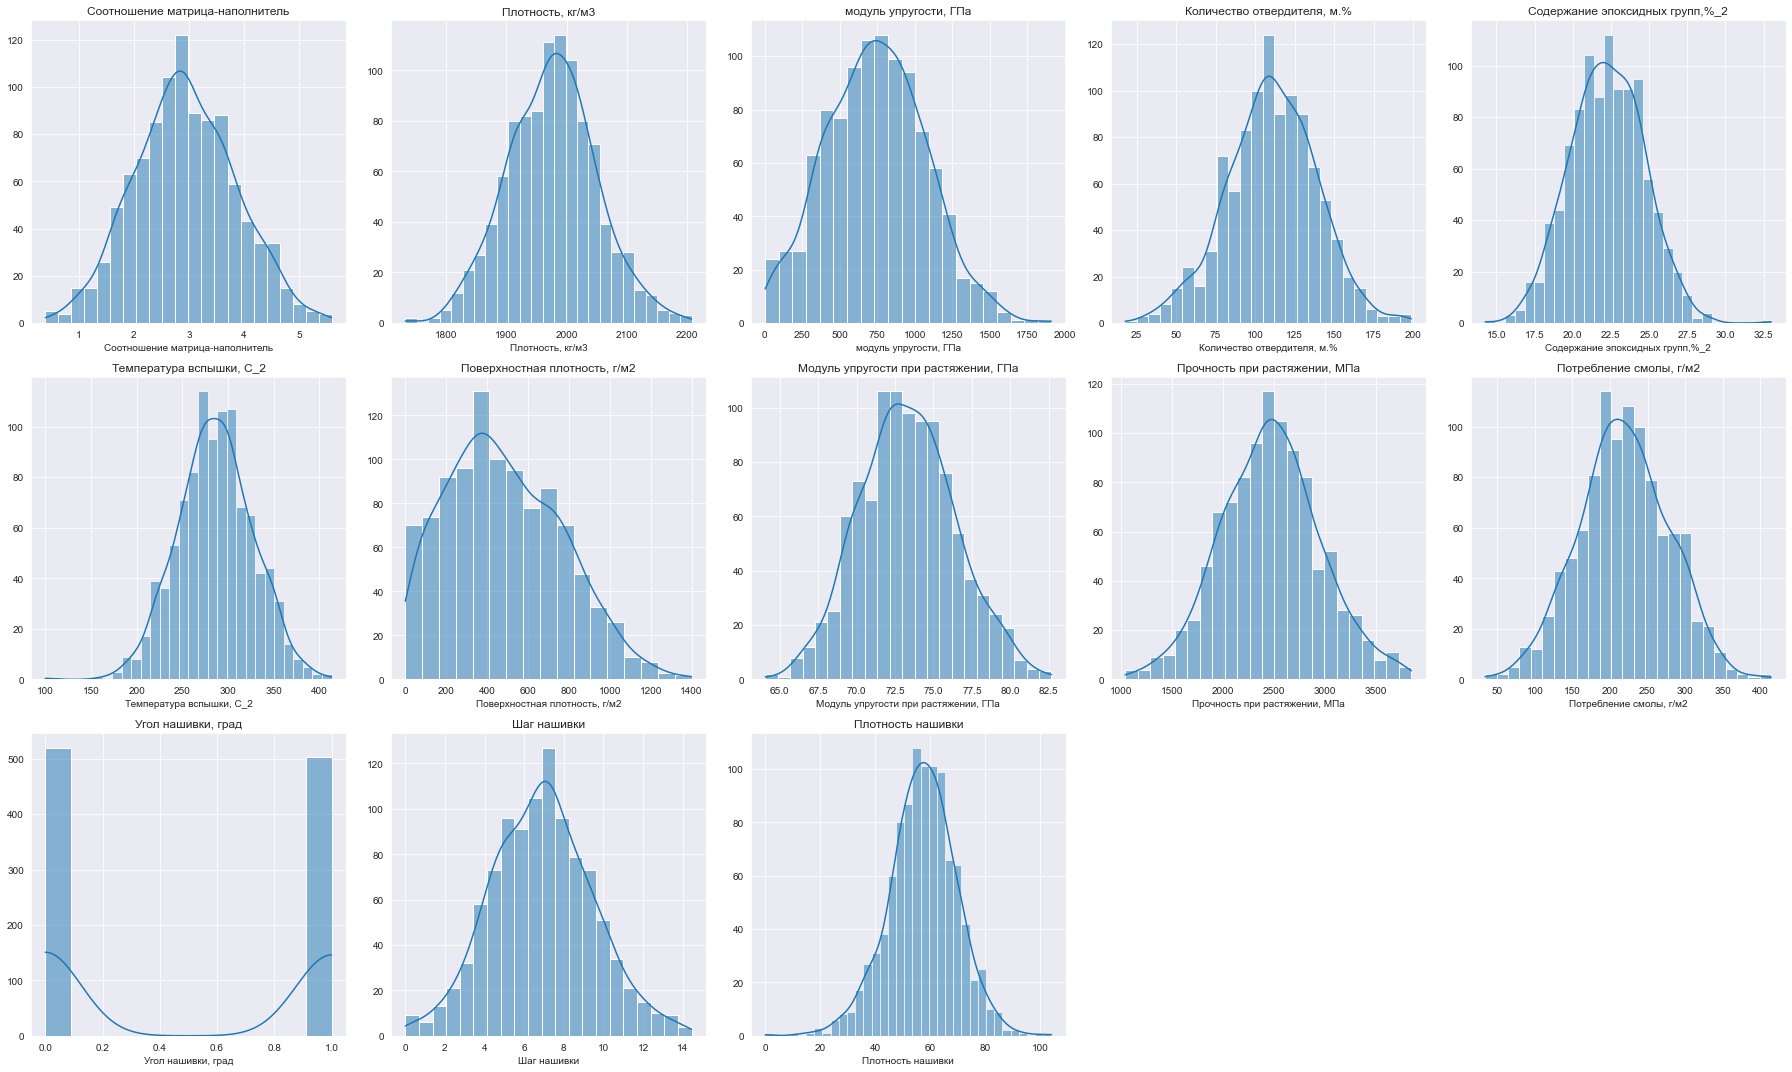

In [74]:
plot_hist(df)

Данные преимущественно имеют нормальное распределение, за исключением угла нашивки, относящегося к категориальным признакам.

Проверим наличие выбросов.

In [75]:
def plot_box(data, cols_per_row=5):
    num_cols = len(data.columns)
    num_rows = math.ceil(num_cols / cols_per_row)
    
    plt.figure(figsize=(cols_per_row * 5, num_rows * 5))
    
    for i, col in enumerate(data.columns, 1):
        plt.subplot(num_rows, cols_per_row, i)
        sns.boxplot(y=data[col])
        plt.title(col)
        plt.ylabel(None)
    
    plt.tight_layout()
    plt.show()

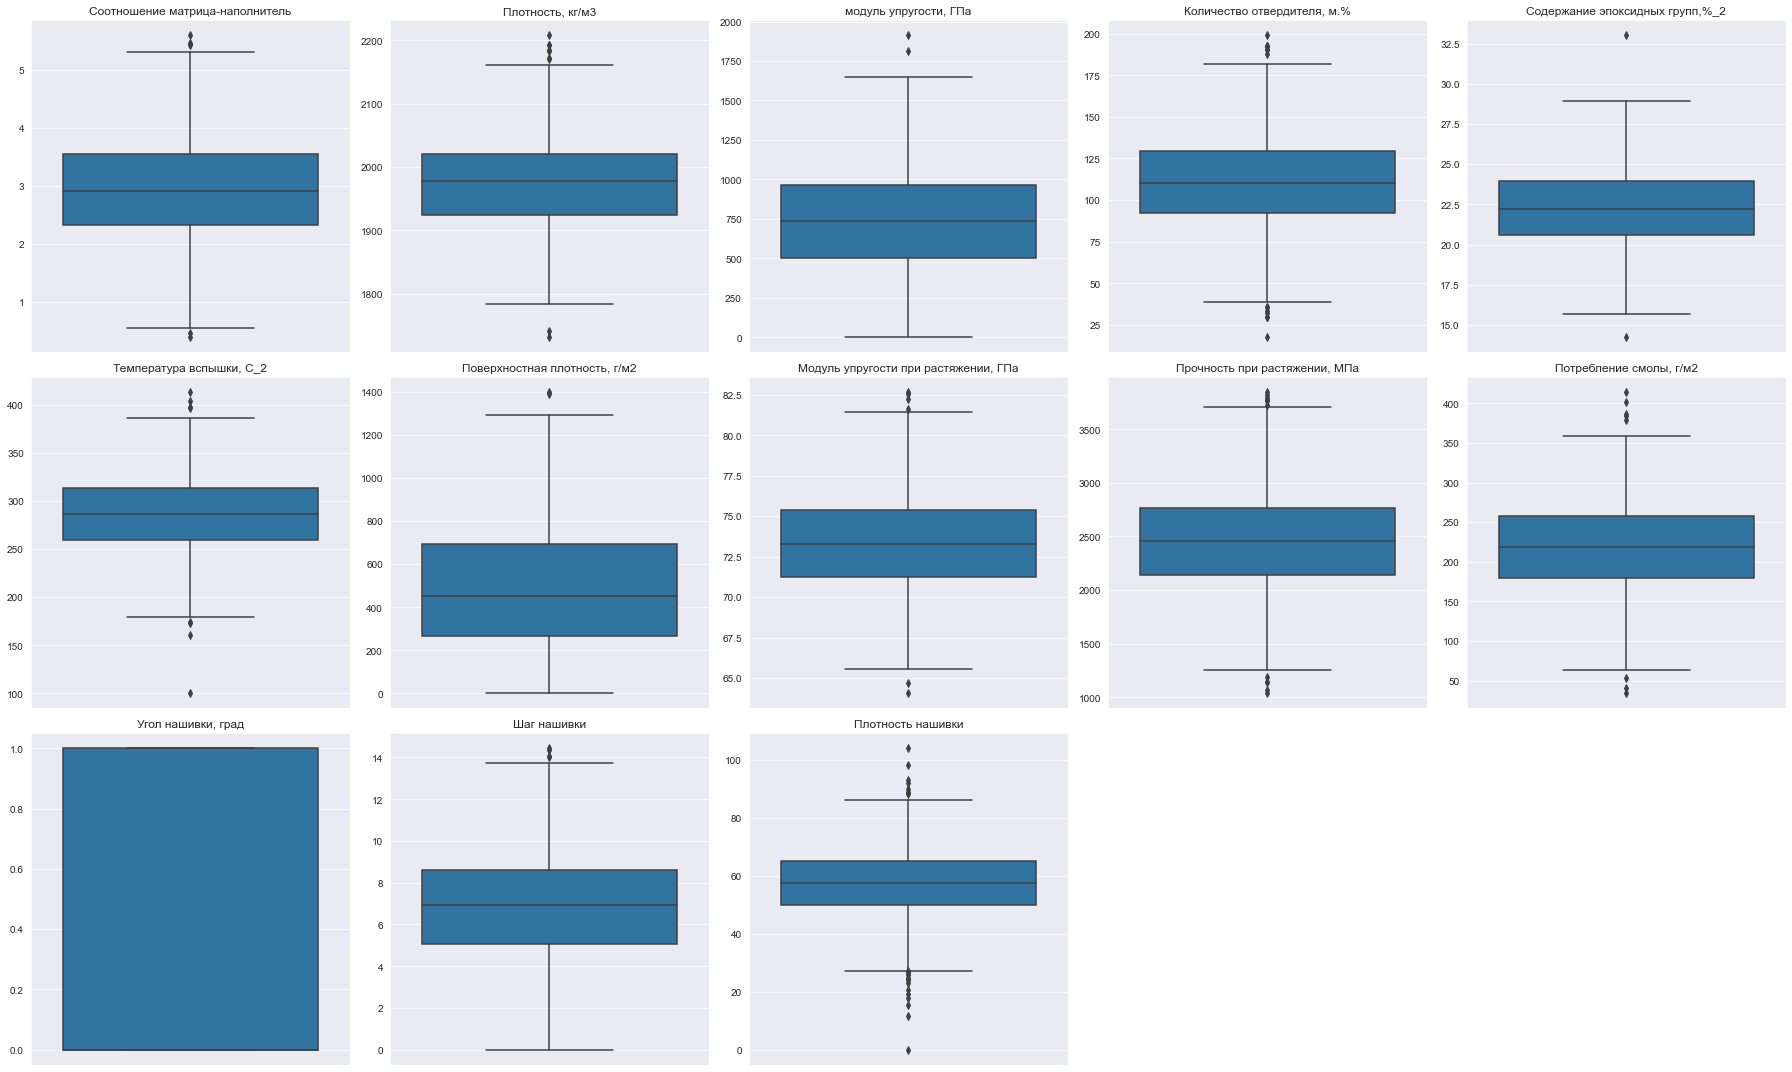

In [76]:
plot_box(df)

In [112]:
import scipy.stats as stats

def plot_qq(data, cols_per_row=5):
    num_cols = len(data.columns)
    num_rows = math.ceil(num_cols / cols_per_row)
    
    plt.figure(figsize=(cols_per_row * 5, num_rows * 5))
    
    for i, col in enumerate(data.columns, 1):
        plt.subplot(num_rows, cols_per_row, i)
        stats.probplot(data[col].dropna(), dist="norm", plot=plt)
        plt.title(col)
        plt.ylabel(None)
    
    plt.tight_layout()
    plt.show()

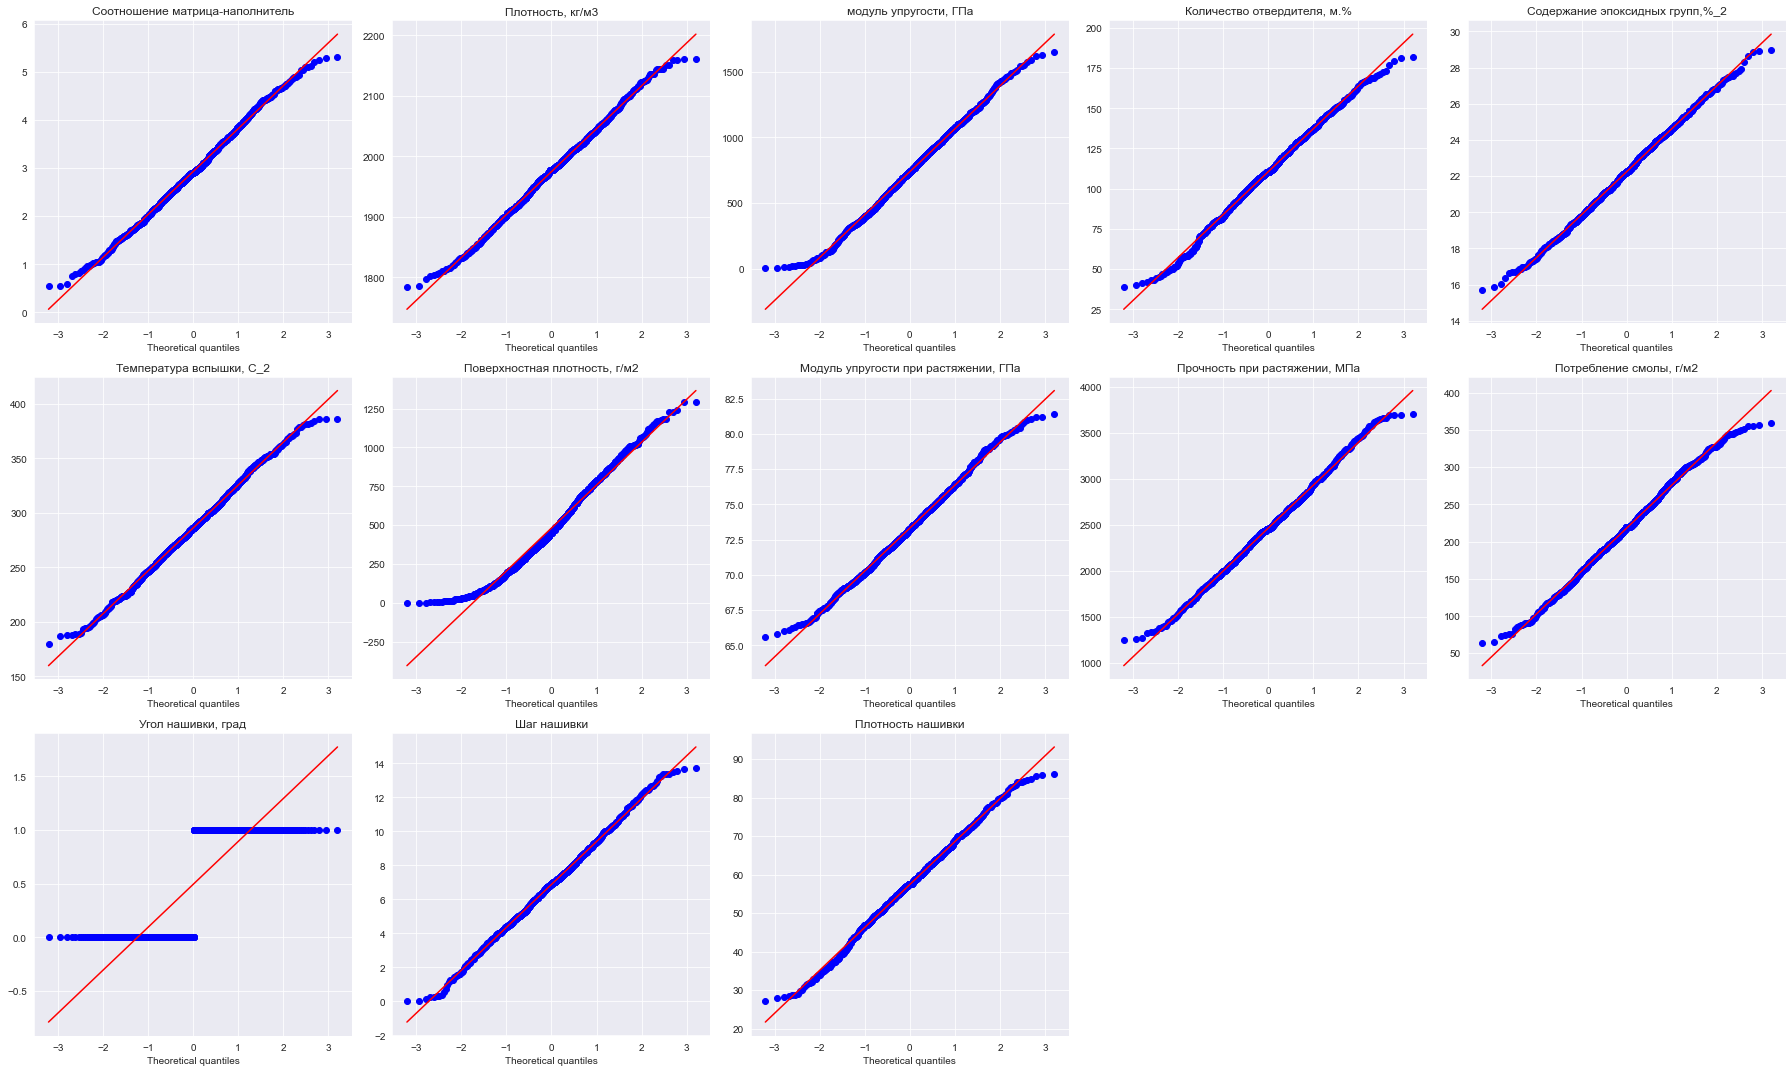

In [113]:
plot_qq(df)

In [82]:
def plot_pair(data, hue=None):
    sns.pairplot(data, hue=hue, diag_kind='kde')
    plt.show()

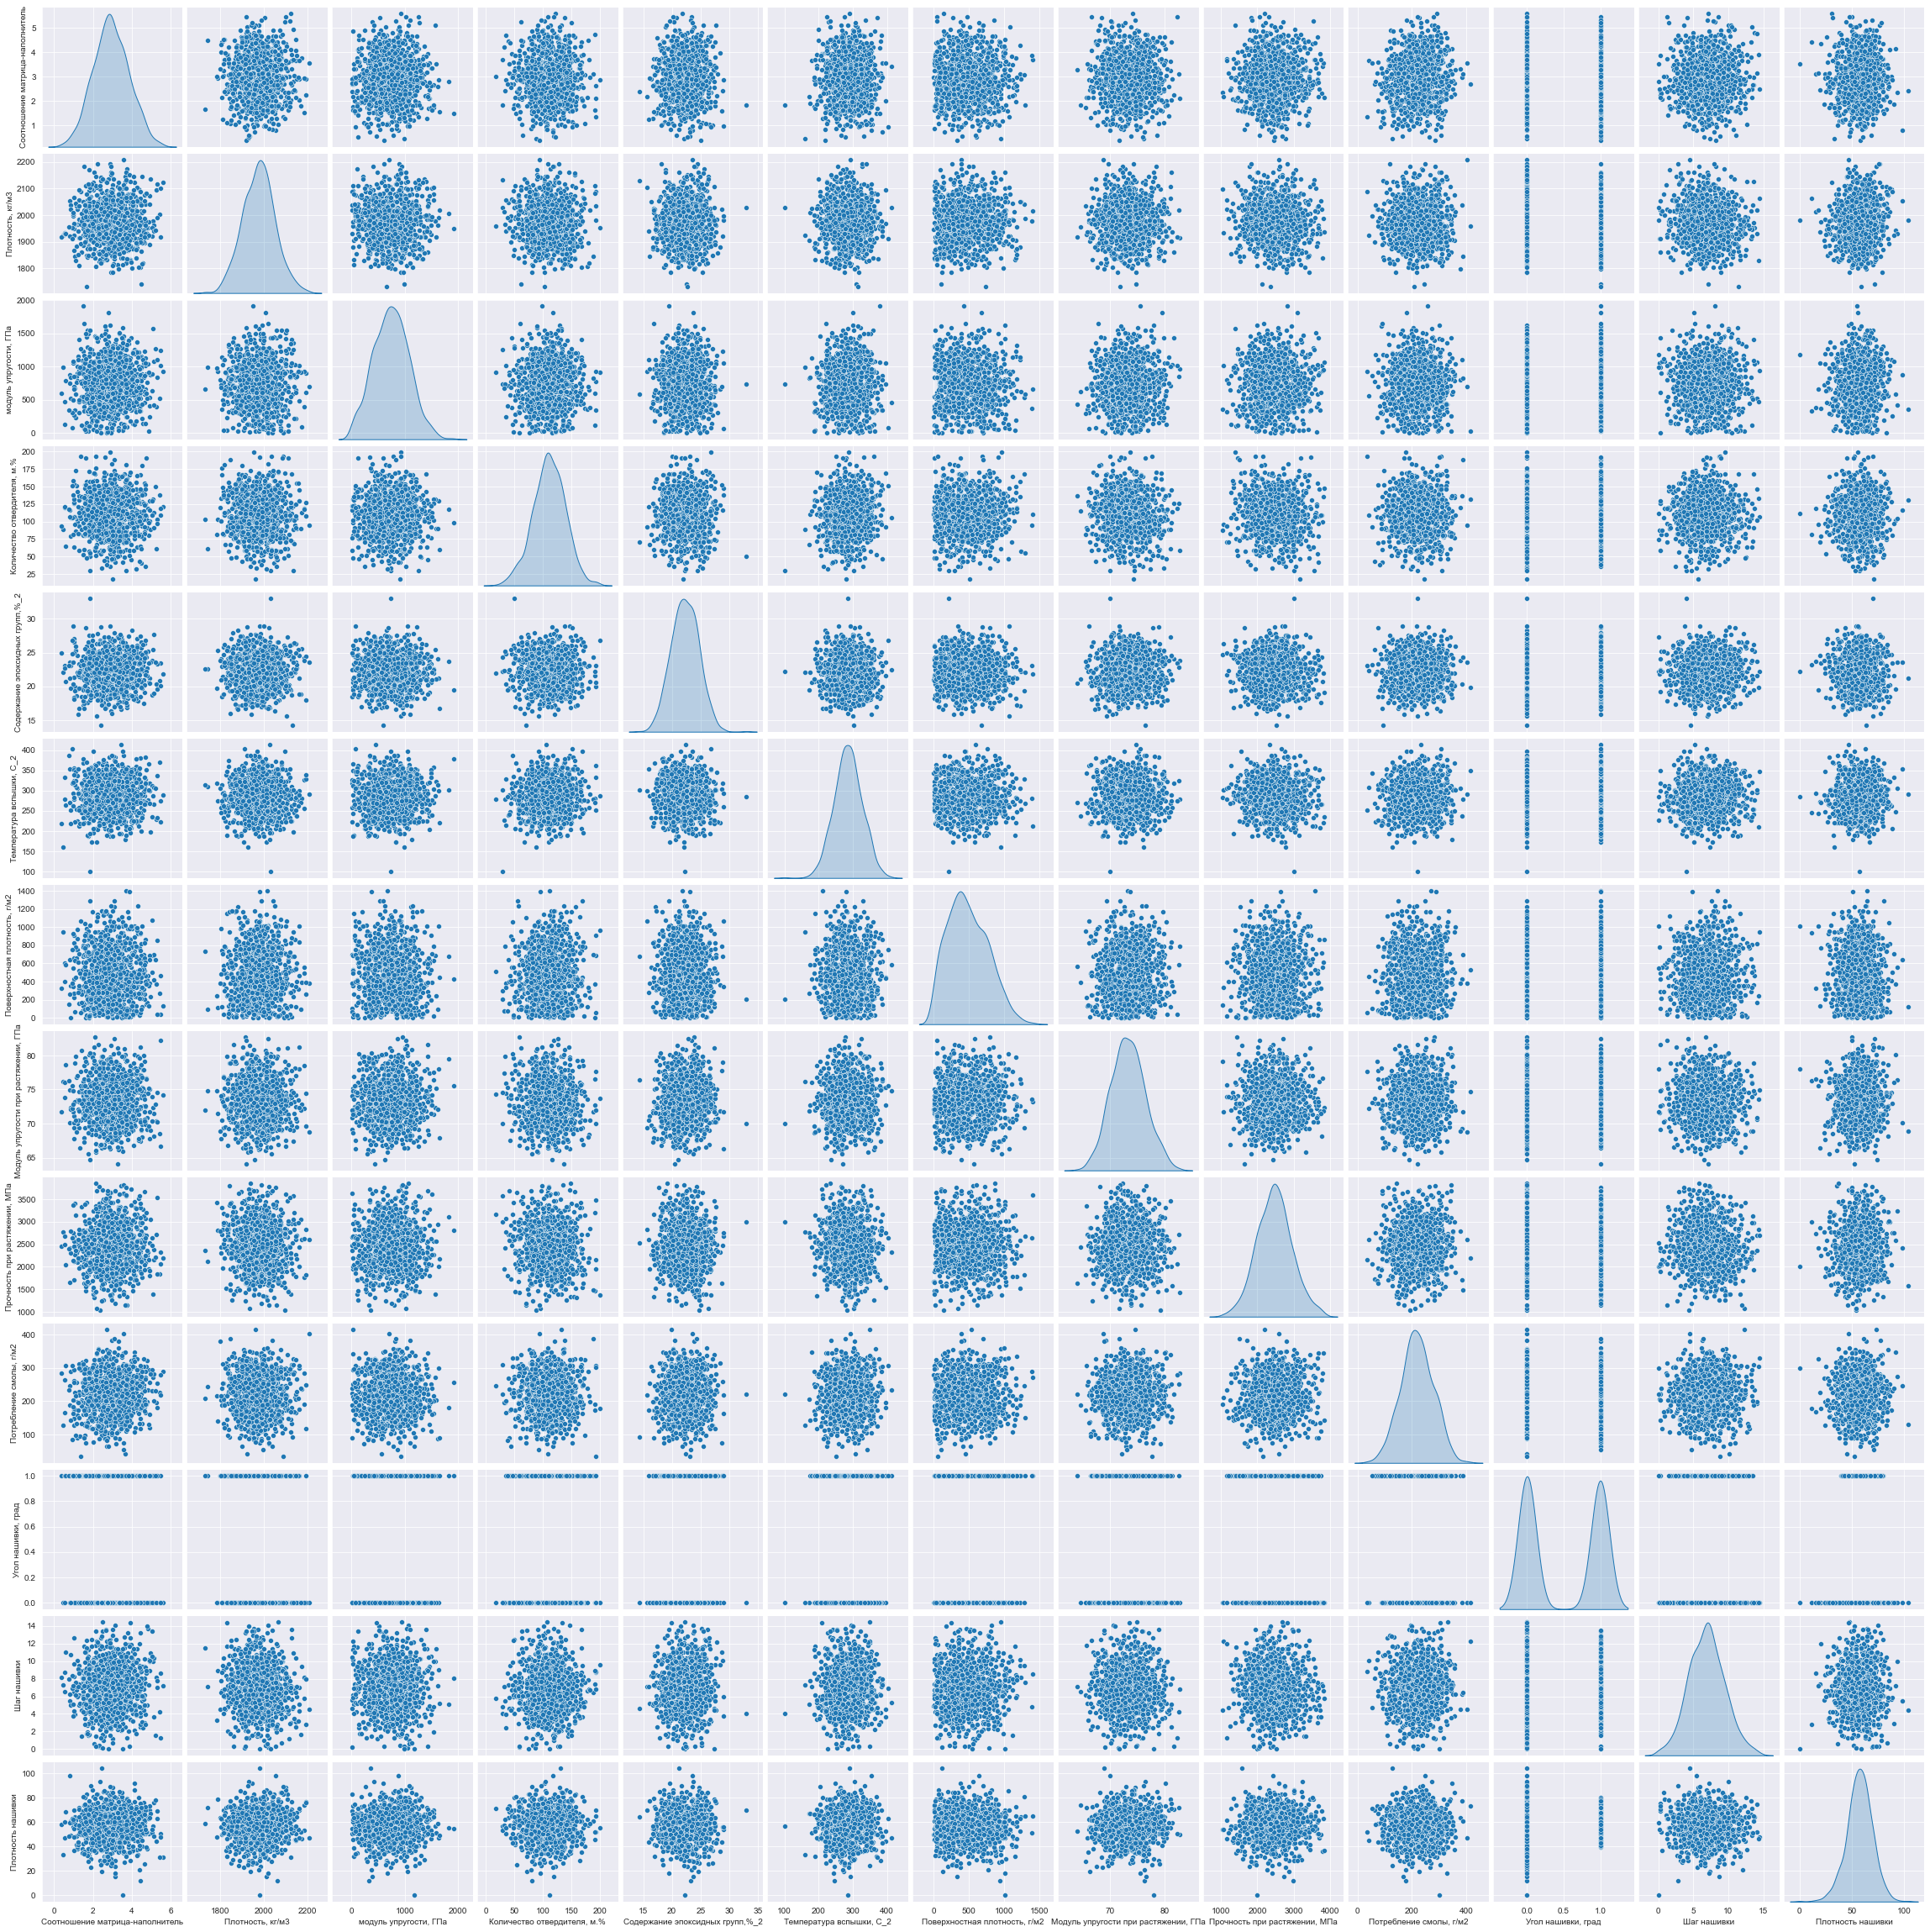

In [83]:
plot_pair(df)

In [245]:
def plot_heatmap(data, annot=True, cmap='bwr'):
    mask = np.triu(df.corr())
    plt.figure(figsize=(12, 10))
    correlation_matrix = data.corr()
    sns.heatmap(correlation_matrix, mask=mask, annot=True, square=True, cmap=cmap)
    plt.xticks(rotation=45, ha='right')
    plt.title(None)
    plt.show()

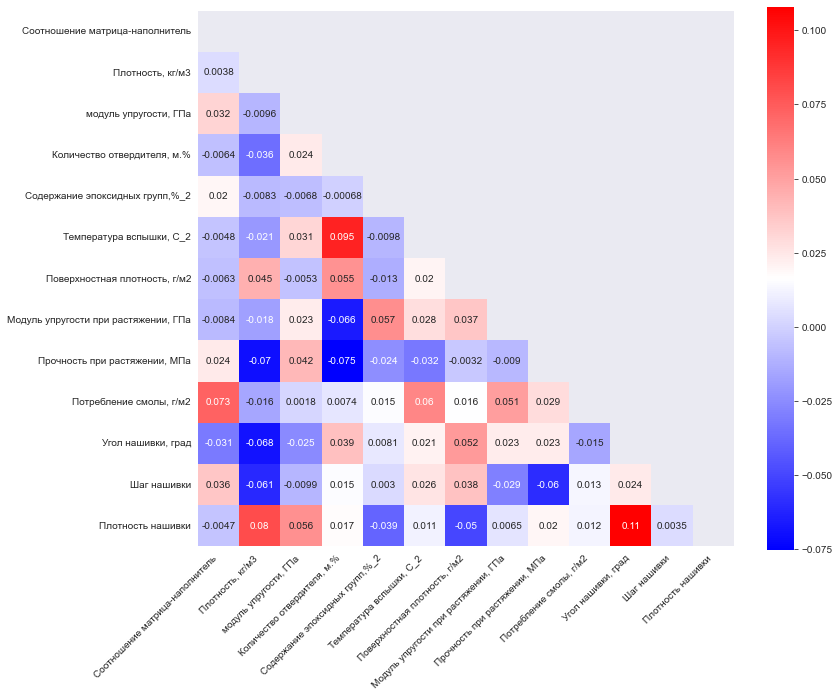

In [138]:
plot_heatmap(df)

Попарные графики распределений и тепловая карта показывает отсутствие сильных линейных зависимостей среди показателей. Однако зависимости могут носить и нелинейный характер, например, при увеличении значений одного показателя, значения другого могут стремится к нулю и т.д. 
Определяем выбросы методом 3-х сигм и заменяем их на нулевые значения.

In [272]:
def replace_outliers_with_nan(data):
    for x in data.columns:
        q75, q25 = np.percentile(data[x].dropna(), [75, 25])
        intr_qr = q75 - q25
        
        max_val = q75 + (1.5 * intr_qr)
        min_val = q25 - (1.5 * intr_qr)
        
        data.loc[data[x] < min_val, x] = np.nan
        data.loc[data[x] > max_val, x] = np.nan

In [273]:
replace_outliers_with_nan(df)

Проверяем количество выбросов.

In [97]:
df.isnull().sum()

Соотношение матрица-наполнитель          6
Плотность, кг/м3                         9
модуль упругости, ГПа                    2
Количество отвердителя, м.%             14
Содержание эпоксидных групп,%_2          2
Температура вспышки, С_2                 8
Поверхностная плотность, г/м2            2
Модуль упругости при растяжении, ГПа     6
Прочность при растяжении, МПа           11
Потребление смолы, г/м2                  8
Угол нашивки, град                       0
Шаг нашивки                              4
Плотность нашивки                       21
dtype: int64

Количество выбросов незначительно. Можно просто избавиться от них, однако я предпочла заменить их на медианные показатели, так как наш датасет сравнительно небольшой.

In [274]:
df = df.fillna(df.median())
#df = df.dropna()

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1023 entries, 0 to 1022
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       1023 non-null   float64
 1   Плотность, кг/м3                      1023 non-null   float64
 2   модуль упругости, ГПа                 1023 non-null   float64
 3   Количество отвердителя, м.%           1023 non-null   float64
 4   Содержание эпоксидных групп,%_2       1023 non-null   float64
 5   Температура вспышки, С_2              1023 non-null   float64
 6   Поверхностная плотность, г/м2         1023 non-null   float64
 7   Модуль упругости при растяжении, ГПа  1023 non-null   float64
 8   Прочность при растяжении, МПа         1023 non-null   float64
 9   Потребление смолы, г/м2               1023 non-null   float64
 10  Угол нашивки, град                    1023 non-null   float64
 11  Шаг нашивки      

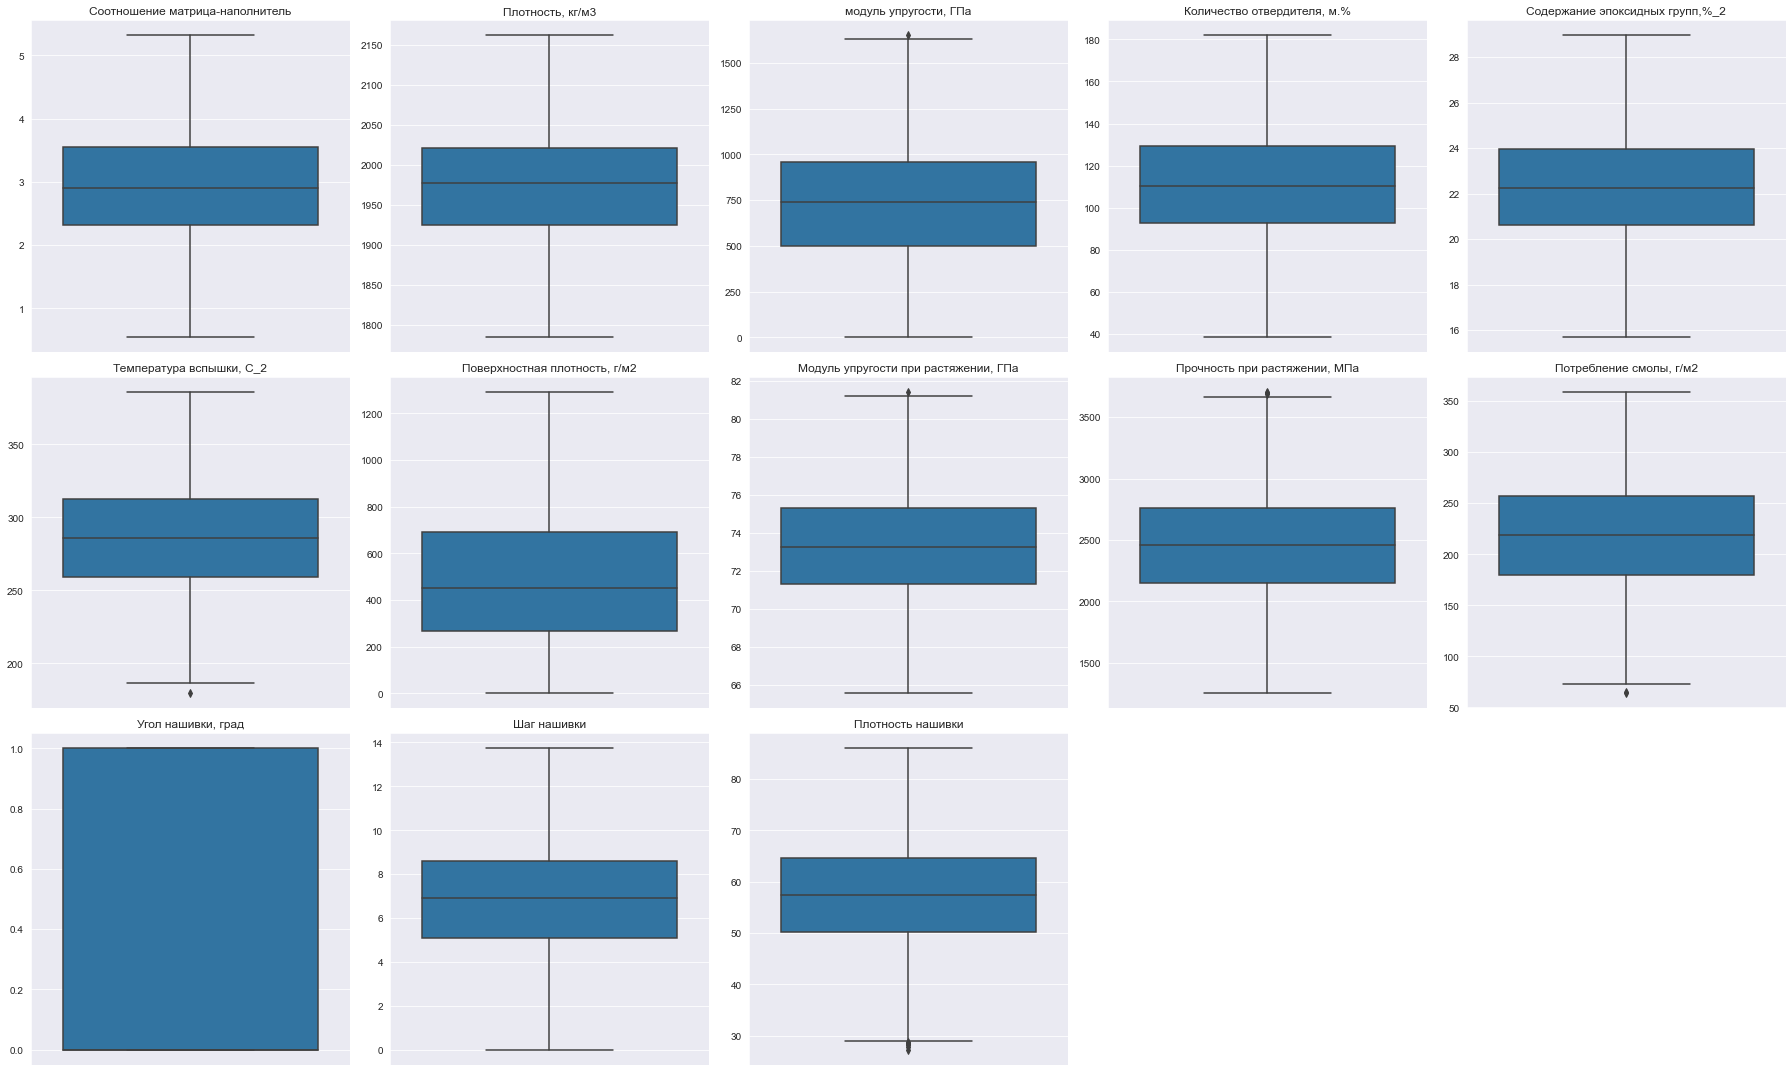

In [101]:
plot_box(df)

In [163]:
for col in df_log.columns:
    print(f"Minimum value of {col}: {df[col].min()}")
    print(f"Maximum value of {col}: {df[col].max()}")

Minimum value of Соотношение матрица-наполнитель: 0.389402605178414
Maximum value of Соотношение матрица-наполнитель: 5.59174159869754
Minimum value of Плотность, кг/м3: 1731.764635096
Maximum value of Плотность, кг/м3: 2207.77348061119
Minimum value of модуль упругости, ГПа: 2.4369087535075
Maximum value of модуль упругости, ГПа: 1911.53647700054
Minimum value of Количество отвердителя, м.%: 17.7402745562519
Maximum value of Количество отвердителя, м.%: 198.953207190451
Minimum value of Содержание эпоксидных групп,%_2: 14.2549854977161
Maximum value of Содержание эпоксидных групп,%_2: 33.0
Minimum value of Температура вспышки, С_2: 100.0
Maximum value of Температура вспышки, С_2: 413.273418243566
Minimum value of Поверхностная плотность, г/м2: 0.603739925153945
Maximum value of Поверхностная плотность, г/м2: 1399.54236233989
Minimum value of Модуль упругости при растяжении, ГПа: 64.0540605597917
Maximum value of Модуль упругости при растяжении, ГПа: 82.682051035271
Minimum value of Пр

In [104]:
df[df['Шаг нашивки']==0]

Соотношение матрица-наполнитель  Плотность, кг/м3  модуль упругости, ГПа  \
19                         3.532338            1980.0                 1183.0   

    Количество отвердителя, м.%  Содержание эпоксидных групп,%_2  \
19                       111.86                        22.267857   

    Температура вспышки, С_2  Поверхностная плотность, г/м2  \
19                284.615385                         1010.0   

    Модуль упругости при растяжении, ГПа  Прочность при растяжении, МПа  \
19                                  78.0                         2000.0   

    Потребление смолы, г/м2  Угол нашивки, град  Шаг нашивки  \
19                    300.0                 0.0          0.0   

    Плотность нашивки  
19          57.516472

In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1023 entries, 0.0 to 1022.0
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       1023 non-null   float64
 1   Плотность, кг/м3                      1023 non-null   float64
 2   модуль упругости, ГПа                 1023 non-null   float64
 3   Количество отвердителя, м.%           1023 non-null   float64
 4   Содержание эпоксидных групп,%_2       1023 non-null   float64
 5   Температура вспышки, С_2              1023 non-null   float64
 6   Поверхностная плотность, г/м2         1023 non-null   float64
 7   Модуль упругости при растяжении, ГПа  1023 non-null   float64
 8   Прочность при растяжении, МПа         1023 non-null   float64
 9   Потребление смолы, г/м2               1023 non-null   float64
 10  Шаг нашивки                           1023 non-null   float64
 11  Плотность н

In [247]:
for col in df.columns:
    if col != 'Соотношение матрица-наполнитель' and col != 'Модуль упругости при растяжении, ГПа':
        df[f'matrix_filler_ratio_minus_{col}'] = df[col] * df['Соотношение матрица-наполнитель']
        df[f'matrix_filler_ratio_div_{col}'] = df[col] / df['Соотношение матрица-наполнитель']
        df[f'matrix_filler_ratio_minus_{col}'] = df[col] - df['Соотношение матрица-наполнитель']

In [122]:
#df.drop(columns=['Температура вспышки, С_2', 'Содержание эпоксидных групп,%_2'], inplace=True)
#df.drop(columns=['Плотность, кг/м3', 'Поверхностная плотность, г/м2', 'Плотность нашивки'], inplace=True)

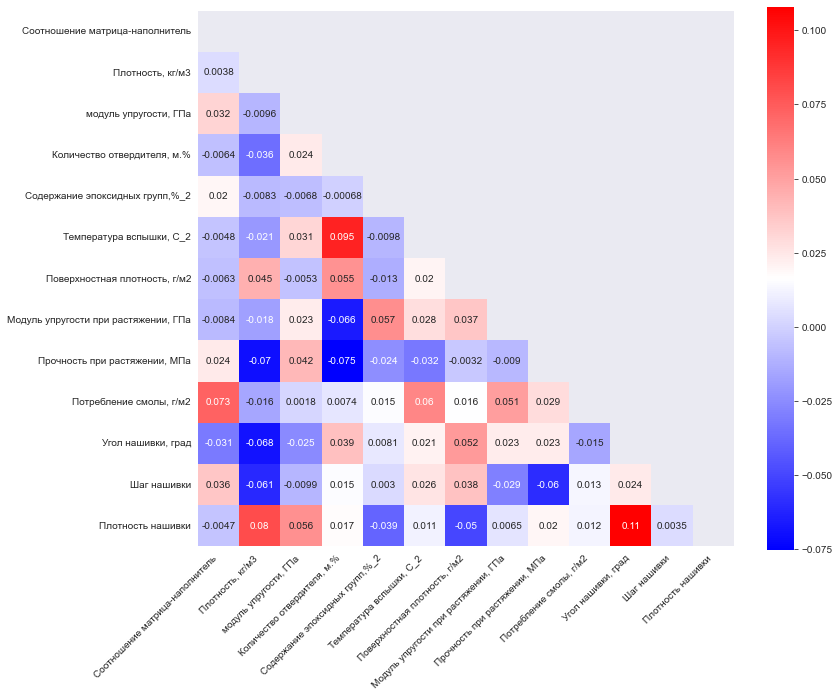

In [324]:
plot_heatmap(df)

In [325]:
df.drop(columns=['Угол нашивки, град'], inplace=True)

In [326]:
epsilon = 1e-10
df[df.abs() < epsilon] = epsilon
df_log = np.log(df)
df_log.head()

Соотношение матрица-наполнитель  Плотность, кг/м3  модуль упругости, ГПа  \
0.0                         0.619039          7.615791               6.604942   
1.0                         0.619039          7.615791               6.604942   
2.0                         0.619039          7.615791               6.604942   
3.0                         0.619039          7.615791               6.604942   
4.0                         1.019328          7.615791               6.624065   

     Количество отвердителя, м.%  Содержание эпоксидных групп,%_2  \
0.0                     3.401197                         3.103144   
1.0                     3.912023                         3.167583   
2.0                     3.910021                         3.496508   
3.0                     4.859812                         3.056357   
4.0                     4.717248                         3.103144   

     Температура вспышки, С_2  Поверхностная плотность, г/м2  \
0.0                  4.605170                       5.347108   
1.0                  5.651139                       5.347108   
2.0                  5.651139                       5.347108   
3.0                  5.703782                       5.347108   
4.0                  5.651139                       5.347108   

     Модуль упругости при растяжении, ГПа  Прочность при растяжении, МПа  \
0.0                              4.248495                       8.006368   
1.0                              4.248495                       8.006368   
2.0                              4.248495                       8.006368   
3.0                              4.248495                       8.006368   
4.0                              4.248495                       8.006368   

     Потребление смолы, г/м2  Шаг нашивки  Плотность нашивки  
0.0                 5.393628     1.386294           4.043051  
1.0                 5.393628     1.386294           4.094345  
2.0                 5.393628     1.386294           4.248495  
3.0                 5.393628     1.609438           3.850148  
4.0                 5.393628     1.609438           4.043051

In [175]:
df.head()

Соотношение матрица-наполнитель  Плотность, кг/м3  модуль упругости, ГПа  \
0.0                         1.857143            2030.0             738.736842   
1.0                         1.857143            2030.0             738.736842   
2.0                         1.857143            2030.0             738.736842   
3.0                         1.857143            2030.0             738.736842   
4.0                         2.771331            2030.0             753.000000   

     Количество отвердителя, м.%  Содержание эпоксидных групп,%_2  \
0.0                        30.00                        22.267857   
1.0                        50.00                        23.750000   
2.0                        49.90                        33.000000   
3.0                       129.00                        21.250000   
4.0                       111.86                        22.267857   

     Температура вспышки, С_2  Поверхностная плотность, г/м2  \
0.0                100.000000                          210.0   
1.0                284.615385                          210.0   
2.0                284.615385                          210.0   
3.0                300.000000                          210.0   
4.0                284.615385                          210.0   

     Модуль упругости при растяжении, ГПа  Прочность при растяжении, МПа  \
0.0                                  70.0                         3000.0   
1.0                                  70.0                         3000.0   
2.0                                  70.0                         3000.0   
3.0                                  70.0                         3000.0   
4.0                                  70.0                         3000.0   

     Потребление смолы, г/м2  Шаг нашивки  Плотность нашивки  
0.0                    220.0          4.0               57.0  
1.0                    220.0          4.0               60.0  
2.0                    220.0          4.0               70.0  
3.0                    220.0          5.0               47.0  
4.0                    220.0          5.0               57.0

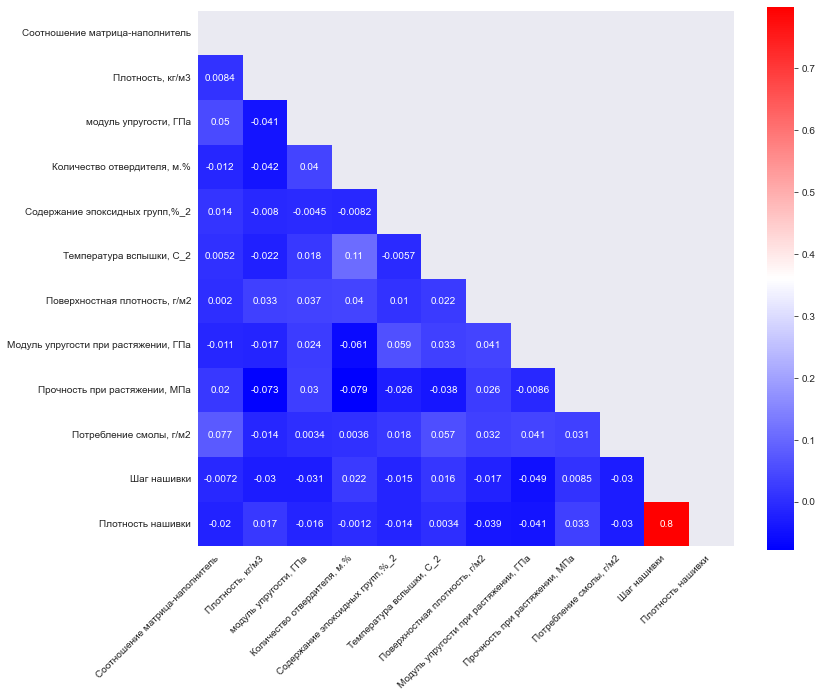

In [327]:
plot_heatmap(df_log)

In [263]:
correlation_matrix = df_log.corr()
correlation_matrix['Соотношение матрица-наполнитель'].sort_values(ascending=False)

Соотношение матрица-наполнитель         1.000000
Потребление смолы, г/м2                 0.076613
модуль упругости, ГПа                   0.049601
Прочность при растяжении, МПа           0.020373
Содержание эпоксидных групп,%_2         0.013528
Плотность, кг/м3                        0.008394
Температура вспышки, С_2                0.005216
Поверхностная плотность, г/м2           0.001967
Шаг нашивки                            -0.007183
Модуль упругости при растяжении, ГПа   -0.010874
Количество отвердителя, м.%            -0.012070
Плотность нашивки                      -0.019987
Name: Соотношение матрица-наполнитель, dtype: float64

Нормализуем значения.

In [328]:
min_max_scaler = MinMaxScaler()
df_norm = pd.DataFrame(min_max_scaler.fit_transform(df_log), columns = df.columns, index=df.index)

Построим модели для предсказания прочности при растяжении, МПа. Посмотрим, с какими показателями он коррелирует и выберем на этом основании кол-во компонент для PCA.

In [344]:
a = df_norm.describe()
a.T

count      mean       std  min  \
Соотношение матрица-наполнитель       1023.0  0.736198  0.134307  0.0   
Плотность, кг/м3                      1023.0  0.539868  0.153773  0.0   
модуль упругости, ГПа                 1023.0  0.834045  0.103945  0.0   
Количество отвердителя, м.%           1023.0  0.741330  0.120003  0.0   
Содержание эпоксидных групп,%_2       1023.0  0.523060  0.130406  0.0   
Температура вспышки, С_2              1023.0  0.732736  0.104770  0.0   
Поверхностная плотность, г/м2         1023.0  0.827513  0.118977  0.0   
Модуль упругости при растяжении, ГПа  1023.0  0.526178  0.166522  0.0   
Прочность при растяжении, МПа         1023.0  0.645356  0.157151  0.0   
Потребление смолы, г/м2               1023.0  0.727297  0.122663  0.0   
Шаг нашивки                           1023.0  0.966639  0.036316  0.0   
Плотность нашивки                     1023.0  0.976515  0.031746  0.0   

                                           25%       50%       75%  max  
Соотношение матрица-наполнитель       0.669485  0.754465  0.829760  1.0  
Плотность, кг/м3                      0.433803  0.546665  0.636775  1.0  
модуль упругости, ГПа                 0.798803  0.857543  0.896947  1.0  
Количество отвердителя, м.%           0.682913  0.756967  0.823099  1.0  
Содержание эпоксидных групп,%_2       0.439092  0.529389  0.618727  1.0  
Температура вспышки, С_2              0.670864  0.740314  0.804150  1.0  
Поверхностная плотность, г/м2         0.786109  0.854099  0.909331  1.0  
Модуль упругости при растяжении, ГПа  0.416795  0.526520  0.636585  1.0  
Прочность при растяжении, МПа         0.551038  0.658629  0.748501  1.0  
Потребление смолы, г/м2               0.666337  0.745761  0.809975  1.0  
Шаг нашивки                           0.959343  0.971350  0.979768  1.0  
Плотность нашивки                     0.973391  0.978488  0.982987  1.0

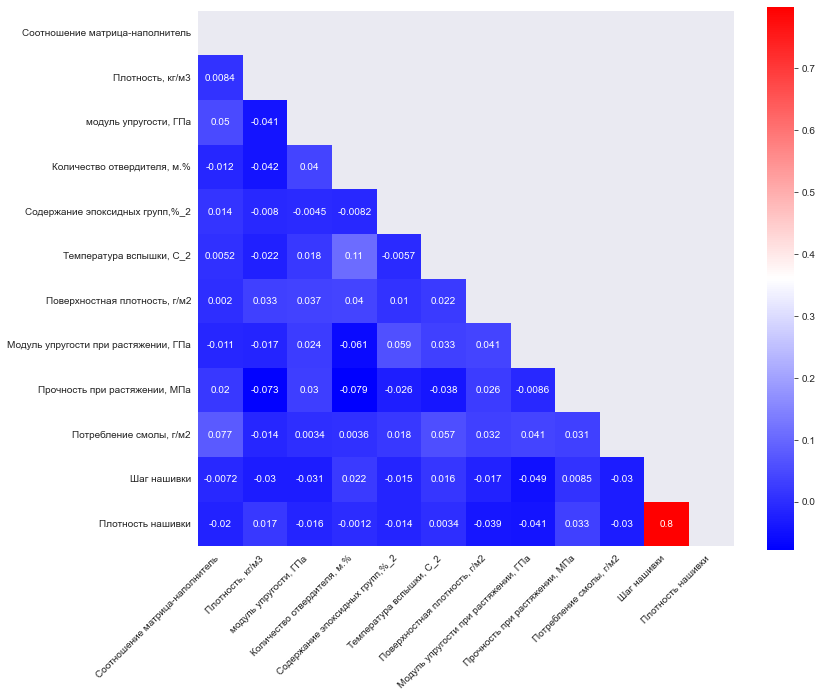

In [329]:
plot_heatmap(df_norm)

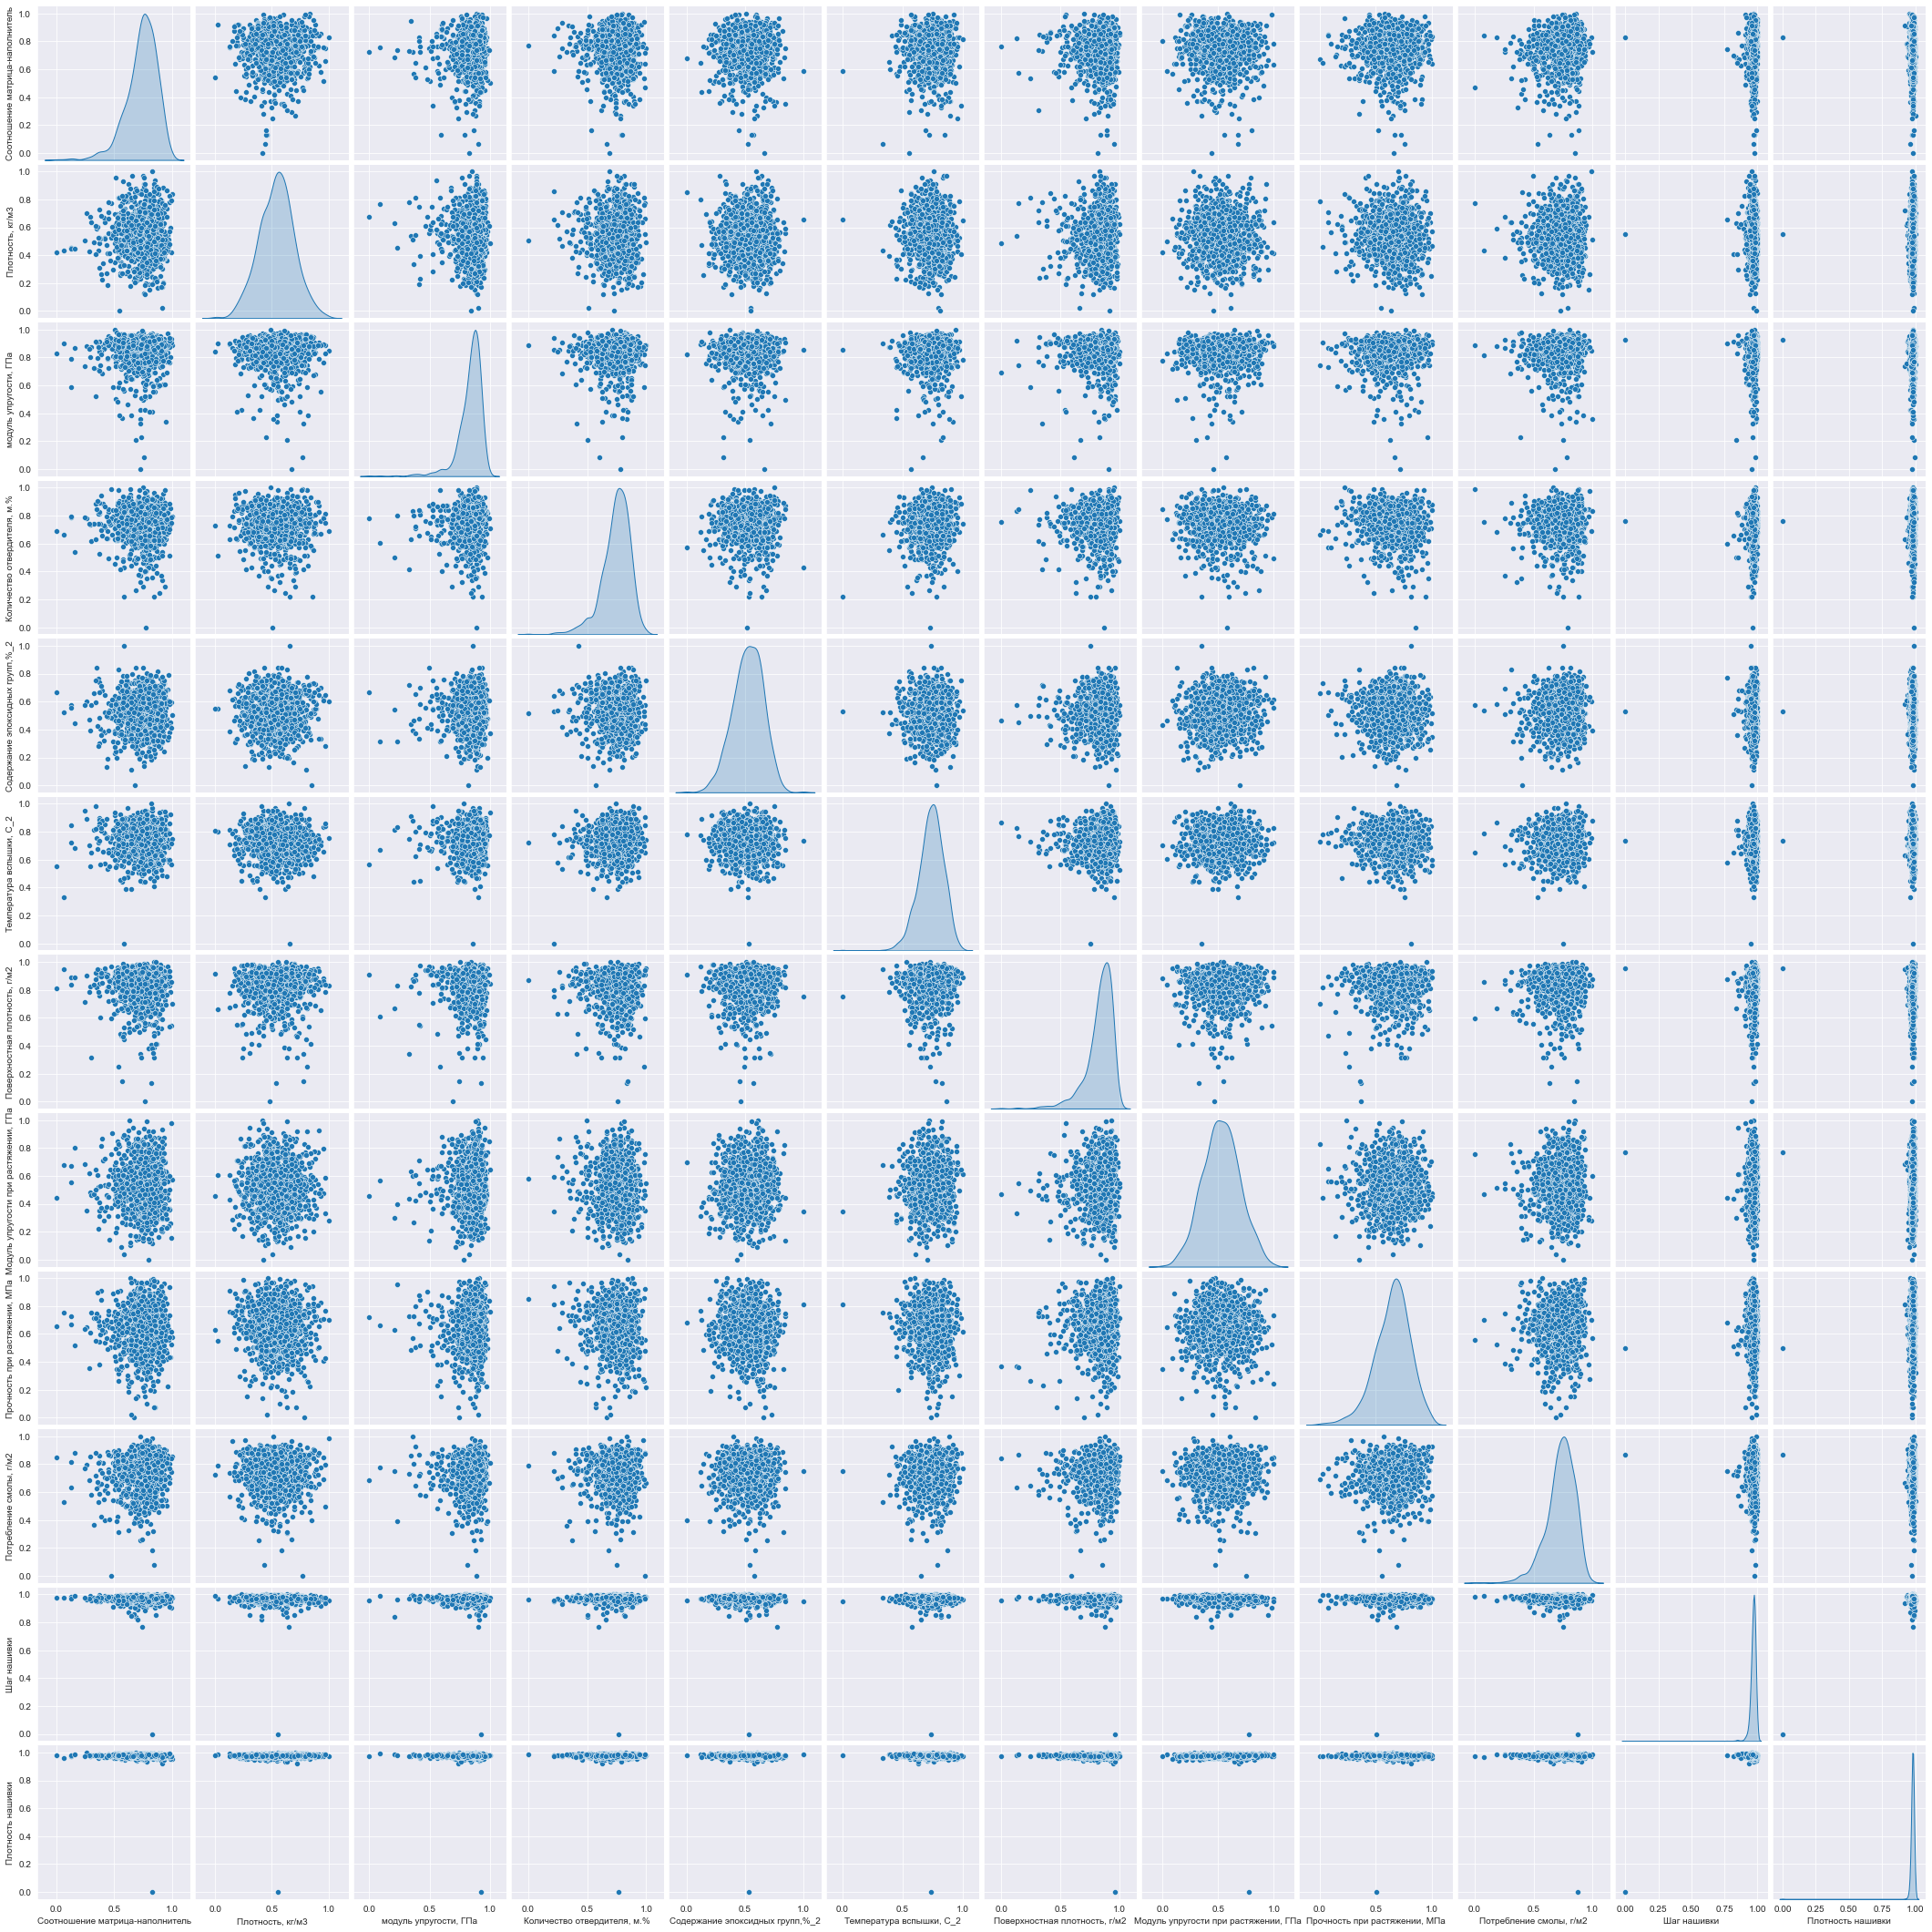

In [330]:
plot_pair(df_norm)

In [345]:
y_pr = df_norm['Модуль упругости при растяжении, ГПа']
X_pr = df_norm.drop(['Модуль упругости при растяжении, ГПа'], axis = 1)

In [346]:
X_train_pr, X_test_pr, y_train_pr, y_test_pr = train_test_split(X_pr, y_pr, test_size = 0.30, random_state=42)

print(X_train_pr.shape)
print(y_train_pr.shape)
print(X_test_pr.shape)
print(y_test_pr.shape)

(716, 11)
(716,)
(307, 11)
(307,)


Для определения качества моделей нам потребуется базовая модель, предсказывающая среднее значение. В качестве такой модели будем использовать DummyRegressor. Модель будет выдавать прогноз, построенный на повторении среднего показателя по множеству.

In [341]:
#Dummy Regressor

dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train_pr, y_train_pr)

y_pred = dummy_reg.predict(X_test_pr)

mse_test = mean_squared_error(y_pred, y_test_pr)
rmse_test = np.sqrt(mse_test)

print("The root mean squared error (RMSE) on test set:", rmse_test)

The root mean squared error (RMSE) on test set: 0.16906908803136658


In [352]:
from sklearn.model_selection import RandomizedSearchCV

In [350]:
#Linear regression

lin_reg = LinearRegression()


grid_param = {
    'fit_intercept' : ['True', 'False']
}

gd_sr_lin_reg = GridSearchCV(estimator=lin_reg,
                             param_grid=grid_param,
                             scoring='neg_root_mean_squared_error',
                             cv=10,
                             n_jobs=-1)

gd_sr_lin_reg.fit(X_train_pr, y_train_pr)

gd_sr_lin_reg.best_params_

lr_upr = gd_sr_lin_reg.best_estimator_
print(f'RMSE-score Linear Regression для модуля упругости при растяжении: {lr_upr.score(X_test_pr, y_test_pr).round(3)}')

RMSE-score Linear Regression для модуля упругости при растяжении: -0.02


In [355]:
#Gradient Boosting

gbr = GradientBoostingRegressor()


grid_param = {
    'max_depth': range(1,10),
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': range(2, 10),
    'min_samples_split': range(10, 50, 5),
    'n_estimators': range(10, 1000, 10),
    'learning_rate': [0.01,0.05,0.1,1,0.5]
}

gd_sr_gbr = RandomizedSearchCV(gbr,
                               grid_param,
                               scoring='neg_root_mean_squared_error',
                               cv=10,
                               n_jobs=-1,
                               verbose=4)

gd_sr_gbr.fit(X_train_pr, y_train_pr)

gd_sr_gbr.best_params_

gbr_pr = gd_sr_gbr.best_estimator_
print(f'R2-score GradientBoosting для модуля упругости при растяжении: {gbr_pr.score(X_test_pr, y_test_pr).round(3)}')

Fitting 10 folds for each of 10 candidates, totalling 100 fits
RMSE-score GradientBoosting для модуля упругости при растяжении: -0.14


In [356]:
#Random Forest Regressor

rfr = RandomForestRegressor(max_features=1, max_leaf_nodes=20, n_estimators=10, n_jobs=-1)


grid_param = {
    'max_depth': range(5, 50),
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': range(2, 20),
    'min_samples_split': range(10, 50, 5),
    'n_estimators': range(10, 1000, 10)
}

gd_sr_rfr = RandomizedSearchCV(rfr,
                               grid_param,
                               scoring='neg_root_mean_squared_error',
                               cv=10,
                               n_jobs=-1,
                               verbose=4)

gd_sr_rfr.fit(X_train_pr, y_train_pr)

gd_sr_rfr.best_params_

rfr_pr = gd_sr_rfr.best_estimator_
print(f'R2-score Random Forest для модуля упругости при растяжении: {rfr_pr.score(X_test_pr, y_test_pr).round(3)}')

Fitting 10 folds for each of 10 candidates, totalling 100 fits
R2-score Random Forest для модуля упругости при растяжении: -0.041
[CV 7/10] END learning_rate=0.05, max_depth=4, max_features=auto, min_samples_leaf=8, min_samples_split=30, n_estimators=620;, score=-0.213 total time=   2.2s
[CV 2/10] END learning_rate=0.05, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=80;, score=-0.167 total time=   0.2s
[CV 7/10] END learning_rate=0.05, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=80;, score=-0.198 total time=   0.2s
[CV 5/10] END learning_rate=0.5, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=20, n_estimators=490;, score=-0.173 total time=   0.9s
[CV 1/10] END learning_rate=0.05, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=25, n_estimators=880;, score=-0.202 total time=   1.0s
[CV 10/10] END learning_rate=0.05, max_depth=4, max_features=sqrt, min_samples

[CV 1/10] END learning_rate=0.05, max_depth=4, max_features=auto, min_samples_leaf=8, min_samples_split=30, n_estimators=620;, score=-0.204 total time=   2.2s
[CV 3/10] END learning_rate=0.05, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=80;, score=-0.190 total time=   0.2s
[CV 10/10] END learning_rate=0.05, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=80;, score=-0.167 total time=   0.2s
[CV 6/10] END learning_rate=0.5, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=20, n_estimators=490;, score=-0.168 total time=   0.9s
[CV 2/10] END learning_rate=0.05, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=25, n_estimators=880;, score=-0.176 total time=   1.0s
[CV 9/10] END learning_rate=0.05, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=25, n_estimators=880;, score=-0.189 total time=   1.2s
[CV 8/10] END learning_rate=0.1, max_depth=8, ma

[CV 8/10] END learning_rate=0.05, max_depth=4, max_features=auto, min_samples_leaf=8, min_samples_split=30, n_estimators=620;, score=-0.195 total time=   2.2s
[CV 6/10] END learning_rate=0.05, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=80;, score=-0.147 total time=   0.2s
[CV 2/10] END learning_rate=0.5, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=20, n_estimators=490;, score=-0.193 total time=   0.9s
[CV 8/10] END learning_rate=0.5, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=20, n_estimators=490;, score=-0.206 total time=   0.9s
[CV 6/10] END learning_rate=0.05, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=25, n_estimators=880;, score=-0.154 total time=   1.1s
[CV 4/10] END learning_rate=0.1, max_depth=8, max_features=auto, min_samples_leaf=7, min_samples_split=20, n_estimators=950;, score=-0.181 total time=   6.1s
[CV 9/10] END learning_rate=0.1, max_depth=8, max_

Выведем результаты на тестовой выборке и сравним модели.

In [361]:
def get_metrics(model):
    predicted = model.predict(X_test_pr)
    R2 = model.best_estimator_
    return (
            R2.score(X_test_pr, y_test_pr).round(3),
            mean_absolute_error(predicted, y_test_pr), 
            np.sqrt(mean_squared_error(predicted, y_test_pr))
           )
                    

In [367]:
models_res = [get_metrics(gd_sr_lin_reg), get_metrics(gd_sr_gbr), get_metrics(gd_sr_rfr)]

result = {
            'Модель': ['Linear Regression', 'GradientBoostingRegressor', 'RandomForestRegressor',], 
            'root_squred_error': [model_res[0] for model_res in models_res],
            'mean_absolute_error': [model_res[1] for model_res in models_res], 
            'root_mean_squared_error': [model_res[2] for model_res in models_res]}

result_df = pd.DataFrame(result)
result_df

Модель  root_squred_error  mean_absolute_error  \
0          Linear Regression             -0.020             0.136412   
1  GradientBoostingRegressor             -0.140             0.141765   
2      RandomForestRegressor             -0.041             0.138379   

   root_mean_squared_error  
0                 0.169387  
1                 0.179020  
2                 0.171080

Модели неудовлетворительно описывают зависимость.  

Создадим нейронную сеть для прогноза соотношения матрица-наполнитель.

In [374]:
#Neural Network

y_mn = df_norm['Соотношение матрица-наполнитель']
X_mn = df_norm.drop(['Соотношение матрица-наполнитель'], axis = 1)

In [375]:
X_train_mn, X_test_mn, y_train_mn, y_test_mn = train_test_split(X_mn, y_mn, test_size = 0.30, shuffle = True, random_state=42)

print(X_train_mn.shape)
print(y_train_mn.shape)
print(X_test_mn.shape)
print(y_test_mn.shape)

(716, 11)
(716,)
(307, 11)
(307,)


Создадим функцию, которая будет строить и компилировать модель Keras с учетом набора гиперпараметров. Начнем с одного скрытого слоя. МЛП с одним скрытым слоем теоретически может моделировать даже самые сложные функции, если в нем достаточно нейронов.

In [451]:
def build_model(input_shape=X_train_mn.shape[1:], n_hidden=4, n_neurons=[128, 64, 32], learning_rate=3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    
    for layer in range(n_hidden):
        neurons = np.random.choice(n_neurons)
        model.add(keras.layers.Dense(neurons, activation="selu", kernel_initializer="lecun_normal"))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dropout(0.2))  # Adjust dropout rate as needed
    
    model.add(keras.layers.Dense(1))
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)  # Using Adam optimizer
    model.compile(loss="mean_absolute_error", optimizer=optimizer, metrics=["mae", "mse"])  # Adding mean absolute error and mean squared error as metrics
    
    return model

In [452]:
model_mn = build_model()

In [453]:
model_mn.summary()

Model: "sequential_349"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5175 (Dense)          (None, 64)                768       
                                                                 
 batch_normalization_5107 (B  (None, 64)               256       
 atchNormalization)                                              
                                                                 
 dropout_5107 (Dropout)      (None, 64)                0         
                                                                 
 dense_5176 (Dense)          (None, 128)               8320      
                                                                 
 batch_normalization_5108 (B  (None, 128)              512       
 atchNormalization)                                              
                                                                 
 dropout_5108 (Dropout)      (None, 128)            

In [ ]:
history = model_mn.fit(X_train_mn, y_train_mn, epochs=100, validation_data=(X_test_mn, y_test_mn))

In [393]:
def plot_loss(history):
    plt.figure(figsize=(12, 8))
    plt.plot(history.history['loss'], label = 'ошибка на обучающей выборке')
    plt.plot(history.history['val_loss'], label = 'ошибка на тестовой выборке')
    plt.xlabel('Эпохи')
    plt.ylabel('значение ошибки')
    plt.legend()
    plt.show

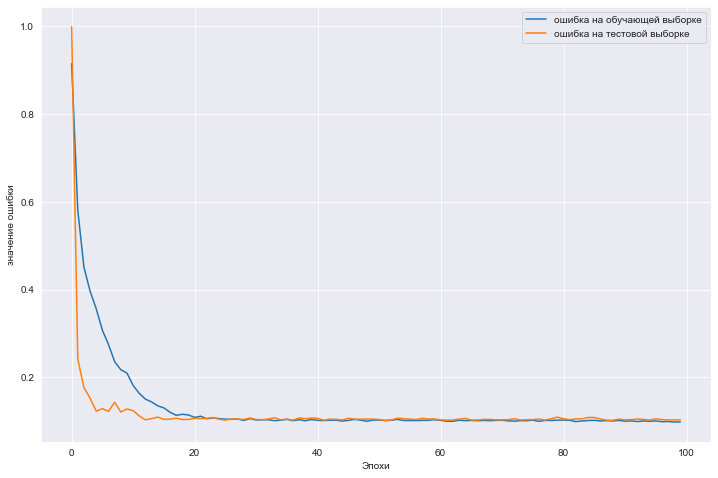

In [394]:
plot_loss(history)

Если ошибка на обучающей выборке значительно меньше, чем на тестовой, модель, вероятно, переобучается, либо есть несоответствие данных между выборками. В нашей модели разница незначительна, значит переобучения скорее всего нет.

In [395]:
model_mn.evaluate(X_test_mn, y_test_mn)

10/10 [==============================] - 0s 1ms/step - loss: 0.1032 - mae: 0.1032 - mse: 0.0179


[0.10321690887212753, 0.10321690887212753, 0.017948566004633904]

Настроим гиперпараметры нашей модели. Обернем модель Keras объектом, имитирующим обычный регрессор Scikit-Learn. Создадим KerasRegressor на основе функции build_model(). Объект KerasRegressor представляет собой тонкую оболочку вокруг модели Keras, построенной с использованием build_model(). Он будет использовать гиперпараметры по умолчанию, которые мы определили в build_model(). Теперь мы можем использовать этот объект как обычный регрессор Scikit-Learn: мы можем обучить его методом fit(), оценить его методом score(), и использовать его для прогнозирования с помощью метода predict().


In [ ]:
#Tuning Hyperparameters
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import reciprocal

keras_reg = KerasRegressor(build_fn=build_model)

# Define the parameter distributions for RandomizedSearchCV
param_distribs = {
       'n_hidden': [0, 1, 2, 3],
       'n_neurons': np.arange(1, 100),
       'learning_rate': reciprocal(3e-4, 3e-2)
}

# Initialize RandomizedSearchCV
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)

# Fit the RandomizedSearchCV object
rnd_search_cv.fit(X_train_mn, 
                  y_train_mn,
                  epochs=100,
                  validation_data=(X_test_mn, y_test_mn), 
                  callbacks=[EarlyStopping(patience=10)])

Выведем лучшие найденные параметры и лучший результат. 

In [460]:
rnd_search_cv.best_params_

{'learning_rate': 0.00394022172297, 'n_hidden': 3, 'n_neurons': 63}

In [461]:
rnd_search_cv.best_score_

-0.10137036442756653

Отметим, что оценка противоположна MAE, потому что в Scikit-Learn это оценка, а не функция потерь (т. е. чем выше, тем лучше).


In [463]:
model_mn = rnd_search_cv.best_estimator_.model
model_mn.evaluate(X_test_mn, y_test_mn)

10/10 [==============================] - 0s 2ms/step - loss: 0.1046 - mae: 0.1046 - mse: 0.0185


[0.10455077141523361, 0.10455077141523361, 0.01849895343184471]

In [458]:
model_mn.summary()

Model: "sequential_380"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5264 (Dense)          (None, 36)                432       
                                                                 
 batch_normalization_5165 (B  (None, 36)               144       
 atchNormalization)                                              
                                                                 
 dropout_5165 (Dropout)      (None, 36)                0         
                                                                 
 dense_5265 (Dense)          (None, 12)                444       
                                                                 
 batch_normalization_5166 (B  (None, 12)               48        
 atchNormalization)                                              
                                                                 
 dropout_5166 (Dropout)      (None, 12)             

Сохраним модель.

In [459]:
model_mn.save('NN_model_Flask/saved_model.h5')

In [ ]:
# Save model as pickle file
# import pickle

# pickle.dump(model_mn, open('NN_model_mn.pkl', 'wb'))
# model_load = pickle.load(open('NN_model_mn.pkl', 'rb'))